In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('classic')
#############################################################
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras import backend as K
####################################################
import os
import cv2
from PIL import Image
import numpy as np


Using TensorFlow backend.


In [2]:
image_directory = 'D:/FINAL_Pruned_Dataset/FINAL_Pruned_Dataset/train/'
SIZE = 224
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

MSIMUT_images = os.listdir(image_directory + 'MSIMUT/')
for i, image_name in enumerate(MSIMUT_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'MSIMUT/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

MSS_images = os.listdir(image_directory + 'MSS/')
for i, image_name in enumerate(MSS_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'MSS/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)


In [3]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

In [ ]:
from keras.utils import normalize
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

In [ ]:
INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)

In [ ]:
from keras.layers import LeakyReLU
from keras.layers import ELU

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.22))

model.add(Flatten())
model.add(Dense(64))
#model.add(Activation('LeakyReLU'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',             #also try adam
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)       

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [10]:
earlystop = EarlyStopping(patience=5)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
#callbacks = [earlystop, ReduceLROnPlateau]
#callbacks = [earlystop, learning_rate_reduction, ModelCheckpoint]

In [15]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval.
filepath="D:/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, learning_rate_reduction, earlystop, log_csv]

In [16]:
history = model.fit(X_train, 
                         y_train, 
                         batch_size = 32, 
                         verbose = 1, 
                         epochs = 100,      
                         validation_data=(X_test,y_test),
                         shuffle = False,
                    callbacks=callbacks_list
                     )



model.save('D:/CNN_krish_model_10epochs.h5')  

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 36s 6ms/step - loss: 0.7074 - accuracy: 0.4978 - val_loss: 0.6924 - val_accuracy: 0.5013

Epoch 00001: val_accuracy improved from -inf to 0.50125, saving model to D:/saved_models/weights-improvement-01-0.50.hdf5
Epoch 2/100
6400/6400 [==============================] - 34s 5ms/step - loss: 0.6939 - accuracy: 0.5327 - val_loss: 0.6938 - val_accuracy: 0.4975

Epoch 00002: val_accuracy did not improve from 0.50125
Epoch 3/100
6400/6400 [==============================] - 34s 5ms/step - loss: 0.6868 - accuracy: 0.5661 - val_loss: 0.6872 - val_accuracy: 0.5131

Epoch 00003: val_accuracy improved from 0.50125 to 0.51313, saving model to D:/saved_models/weights-improvement-03-0.51.hdf5
Epoch 4/100
6400/6400 [==============================] - 34s 5ms/step - loss: 0.6825 - accuracy: 0.5747 - val_loss: 0.6633 - val_accuracy: 0.5769

Epoch 00004: val_accuracy improved from 0.51313 to 0.57687, sa

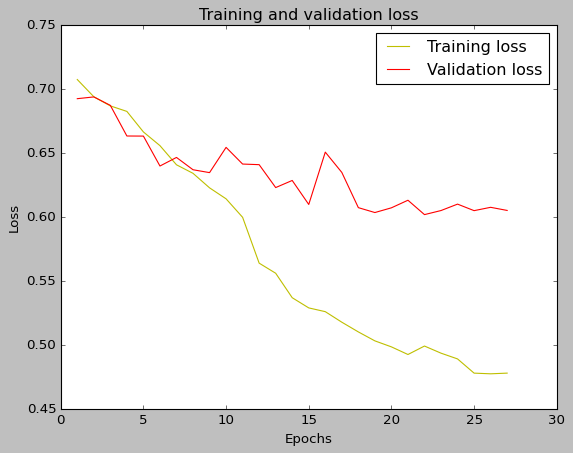

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

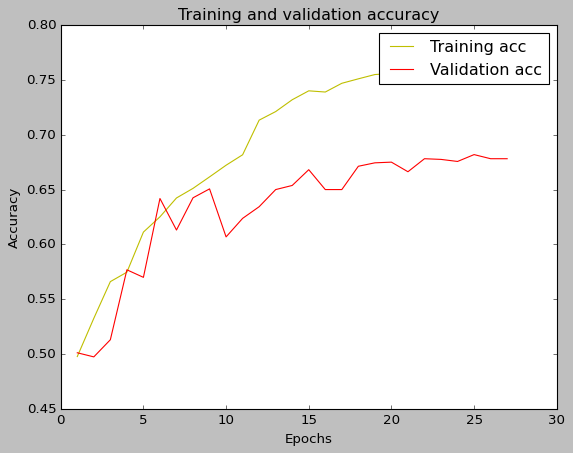

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The prediction for this image is:  [[0.3922205]]
The actual label for this image is:  0


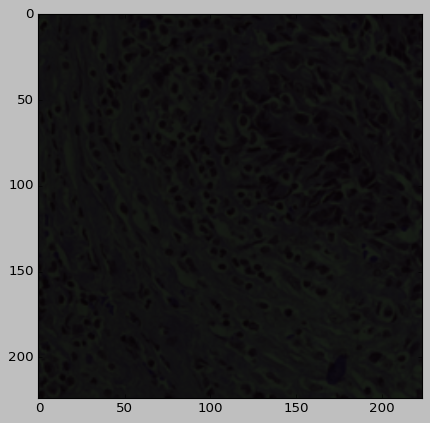

In [19]:
#Test the model on one image (for 300 epochs)
#img 23 is parasitized - correctly predicts near 0 probability
#Img 22, parasitized, correctly lables (low value) but relatively high value.
#img 24 is uninfected, correctly predicts as uninfected
#img 26 is parasitized but incorrectly gives high value for prediction, uninfected.

n=45  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

In [20]:
#Instead f checking for each image, we can evaluate the model on all test data
#for accuracy
################################################################

#We can load the trained model, so we don't have to train again for 300 epochs!
from keras.models import load_model
# load model
model = load_model('D:/CNN_krish_model_10epochs.h5')

#For 300 epochs, giving 82.5% accuracy

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1600/1600 [==============================] - 3s 2ms/step
Accuracy =  67.81250238418579 %


In [30]:
#How do we know how it is doing for parasitized vs uninfected? 
################################################################

#Confusion matrix
#We compare labels and plot them based on correct or wrong predictions.
#Since sigmoid outputs probabilities we need to apply threshold to convert to label.

mythreshold=0.307        
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

[[283 527]
 [ 97 693]]


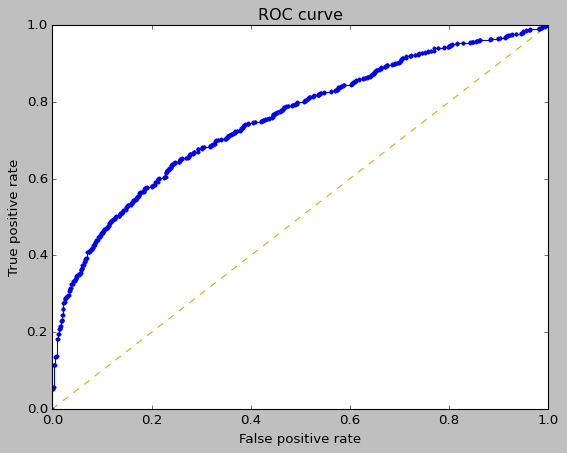

In [31]:
#Check the confusion matrix for various thresholds. Which one is good?
#Need to balance positive, negative, false positive and false negative. 
#ROC can help identify the right threshold.
##################################################################
"""
Receiver Operating Characteristic (ROC) Curve is a plot that helps us 
visualize the performance of a binary classifier when the threshold is varied. 
"""
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


In [32]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  307    0.53728
Name: thresholds, dtype: float32


In [33]:
#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn


#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.7535146116580715
